In [1]:
#!pip install -U transformers openai --quiet

In [2]:
import transformers

transformers.__version__

'4.46.0'

# Causal Language Model

## Settings

In [3]:
from pydantic import BaseModel
from abc import ABC, abstractmethod


class LLMSettings(ABC, BaseModel):    
    class Config:
        arbitrary_types_allowed=True
        protected_namespaces = ()

In [4]:
import os
from dotenv import load_dotenv
from transformers import (AutoModelForCausalLM, AutoModelForVision2Seq,
                          AutoProcessor, AutoTokenizer, PreTrainedModel)

load_dotenv()


class HuggingfaceSettings(LLMSettings):
    model_id: str
    #architecture: PreTrainedModel
    #tokenizer: AutoTokenizer | AutoProcessor
    multimodal: bool
    
class Idefics2Settings(HuggingfaceSettings):
    model_id: str = "HuggingFaceM4/idefics2-8b-chatty"
    architecture: PreTrainedModel = AutoModelForVision2Seq
    tokenizer: AutoTokenizer | AutoProcessor = AutoProcessor
    multimodal: bool = True
    
class OpenAISettings(LLMSettings):
    model_id: str = "gpt-4o-mini"
    api_key: str = os.getenv("openai")
    
    
class Settings:
    @staticmethod
    def get_settings(model_id:str) -> LLMSettings:
        settings = {
            "gpt-4o-mini": OpenAISettings,
            "HuggingFaceM4/idefics2-8b-chatty": Idefics2Settings
        }
        return settings.get(model_id)()

2024-10-27 17:53:54.210884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/

## Model Wrapper

In [5]:
class LLMBase(ABC):
    @abstractmethod
    def generate(question: str, context: list[dict]) -> str:
        pass
        
    def _get_system_prompt(self) -> str:
        return """You are an advanced AI assistant designed for retrieval-augmented generation (RAG). Your responses should be based solely on the context snippets provided to you, which may include both images and text. When answering user queries:
1. Carefully analyze all provided context (images and/ or text).
2. Formulate your response using only the information present in this context.
3. If the answer cannot be determined from the given context, clearly state: 'I cannot answer this based on the provided information.'
Do not use prior knowledge or make assumptions beyond what is explicitly provided. Your goal is to give accurate, relevant responses grounded in the given context."""


### Huggingface

In [6]:
import torch
from PIL import Image
from transformers.generation.utils import GenerateOutput


class HuggingfaceLLM(LLMBase):
    def __init__(self, config: HuggingfaceSettings) -> None:
        self.config: HuggingfaceSettings = config
        self.device = "auto"
        self.model = config.architecture.from_pretrained(
            self.config.model_id, torch_dtype=torch.float16, device_map=self.device
        )
        self.tokenizer = config.tokenizer.from_pretrained(self.config.model_id)
        
    def _build_prompt(self, question: str, context: list[dict]) -> str:
        # System
        system_message: dict = {
            "role":" system",
            "content": [
                {
                    "type": "text",
                    "text": self._get_system_prompt()
                }
            ]
        }
        
        # Initial user
        user_message : dict = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Given context:\n"
                }
            ]
        }
        
        # Contexts
        for result in context:
            if result["image"] and self.config.multimodal:
                user_message["content"].append({"type": "image"})
            user_message["content"].append(
                {
                    "type": "text",
                    "text": result["text"]
                }
            )

        # User question
        user_message["content"].append(
            {
                "type": "text",
                "text": question
            }
        )
        
        return self.tokenizer.apply_chat_template([system_message, user_message])
    
    def _tokenize(self, prompt: str, imgs: list[Image.Image]) -> dict:
        if self.config.multimodal and len(images) > 0:
            return self.tokenizer(text=prompt, images=imgs, return_tensors="pt")
        return self.tokenizer(prompt, return_tensors="pt")
    
    @torch.no_grad()
    def _generate(self, inputs: dict) ->GenerateOutput | torch.LongTensor:
        gen_kwargs = {
            "max_new_tokens": 200,
            "temperature": 0.1,
            "do_sample": False,
        }
        return self.model.generate(**inputs, **gen_kwargs).to("cpu")
        
    def generate(self, question: str, context: list[dict], images: list[Image.Image]) -> str:
        prompt = self._build_prompt(question, context)
        inputs = self._tokenize(prompt, images)
        prompt_length = len(inputs["input_ids"][0])
        inputs = {k: v.to(self.model.device) for k, v in inputs.items()}
        outputs = self._generate(inputs)
        answer = self.tokenizer.decode(
            outputs[0][prompt_length:], skip_special_tokens=True
        )
        torch.cuda.empty_cache()
        return answer

### OpenAI

In [7]:
from openai import OpenAI
import base64
from io import BytesIO

class GPTWrapper(LLMBase):
    def __init__(self, config: OpenAISettings) -> None:
        self.config = config
        self.client = OpenAI(api_key=config.api_key)
        
    def _encode_pil_image(self, pil_image):
        buffered = BytesIO()
        pil_image.save(buffered, format="PNG")
        return base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    def _build_prompt(self, question: str, context: list[dict]) -> list[dict]:
        # System prompt
        system_prompt = {
            "role": "system",
            "content": [
                {
                    "type": "text",
                    "text": self._get_system_prompt()
                }
            ]
        }
        
        # User prompt
        user_message : dict = {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Given context:\n"
                }
            ]
        }
        
        # Contexts
        for result in context:
            if result["image"] and result["image"] is not None:
                img = Image.open(result["image"])
                base64_image = self._encode_pil_image(img)
                user_message["content"].append(
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{base64_image}"
                        }
                    }
                )
            user_message["content"].append(
                {
                    "type": "text",
                    "text": result["text"]
                }
            )

        # User question
        user_message["content"].append(
            {
                "type": "text",
                "text": question
            }
        )
        
        return [system_prompt, user_message]
    
    def generate(self, question: str, context: list[dict], images: list[Image.Image]) -> str:
            messages = self._build_prompt(question, context)
            response = self.client.chat.completions.create(
                model=self.config.model_id,
                messages=messages,
                temperature=0,
                max_tokens=200
            )
            return response.choices[0].message.content

In [8]:
class LLMFactory:
    @staticmethod
    def get_model(model_id: str) -> LLMBase:
        settings = Settings.get_settings(model_id)
        models = {
            "gpt-4o-mini": GPTWrapper,
            "HuggingFaceM4/idefics2-8b-chatty": HuggingfaceLLM
        }
        return models.get(model_id)(settings)

# Dataset

In [9]:
from pathlib import Path

root_path = Path("./dataset_files")
images = list()

# Use rglob to recursively search for files with the given suffix
for file_path in root_path.rglob(f'*.png'):
    if file_path.is_file():
        img = Image.open(file_path)
        images.append(img)
        
f"{len(images)} images found!"

'9 images found!'

In [10]:
questions = [
    "What was the trend or progression of Arctic sea ice cover in the period between 1991-2020?",
    "Which AI Model did perform best in forecasting certain weather situations?",
    "How many countries build MHEWS in the year 2020?",
    "What are the estimated ozone exposure levels in South Asia? (Provide specific numbers if possible.)",
    "Where were the most Meteorological event recorded? (Meteorological event: storm, winter storm,severe weather, hail, tornado, local storm) Give numbers if possible.",
    "Around what time of year is the ozone hole at its largest?",
    "What was the last measured sea level in mm approximately?",
    "In which year was the long-term average of the global combined surface air temperature over land and sea crossed?"
]

## Test Idefics2

In [11]:
model = LLMFactory.get_model("HuggingFaceM4/idefics2-8b-chatty")

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Chat templates should be in a 'chat_template.json' file but found key='chat_template' in the processor's config. Make sure to move your template to its own file.


  0%|          | 0/8 [00:00<?, ?it/s]

SAMPLE 1 ##############################


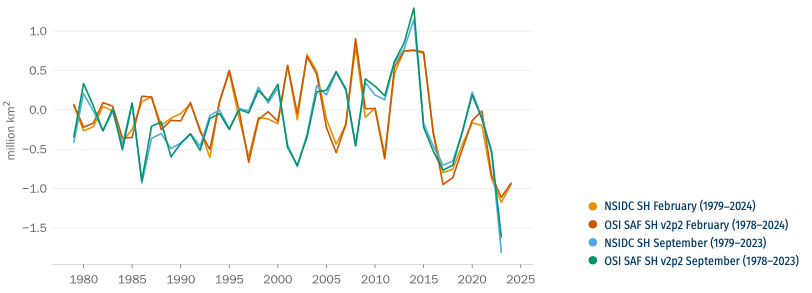

########
Figure 5. Sea-ice extent differences from the 1991–2020 average in the Arctic for the months with maximum ice cover (March) and minimum ice cover (September) from 1979 to March 2024.


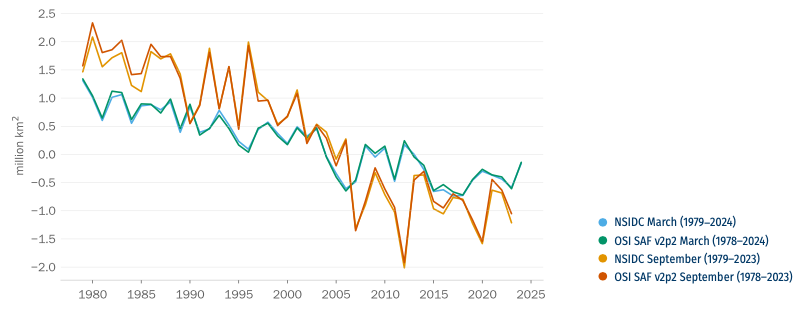

########
Figure 6. Sea-ice extent differences from the 1991–2020 average in the Antarctic for the months with maximum ice cover (September) and minimum ice cover (February) from 1979 to February 2024. 
########
Human influence is very likely the main driver of the decrease in Arctic sea‐ice area between 1979–1988 and 2010–2019 (IPCC, 2023). Arctic sea‐ice cover (both annual and late summer) is currently at its lowest level since at least 1850, and is likely to reach practically ice-free conditions at its summer minimum at least once before 2050. During the period 2019–2023, September Arctic sea‐ice extent was on average around 1 million km2 below the 1991–2020 average (Figure 5). In Antarctica, there was no significant trend in sea‐ice extent from 1979 to 2020 due to regionally opposing change and large internal variability (IPCC, 2021). And while Antarctic sea‐ice extent increased slowly from the start of the satellite era to a maximum in 2014 (Figure 6), it dropped rapidly between 20

/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
 12%|█▎        | 1/8 [00:03<00:22,  3.26s/it]


In the period between 1991-2020, Arctic sea ice cover experienced a decrease.



SAMPLE 2 ##############################


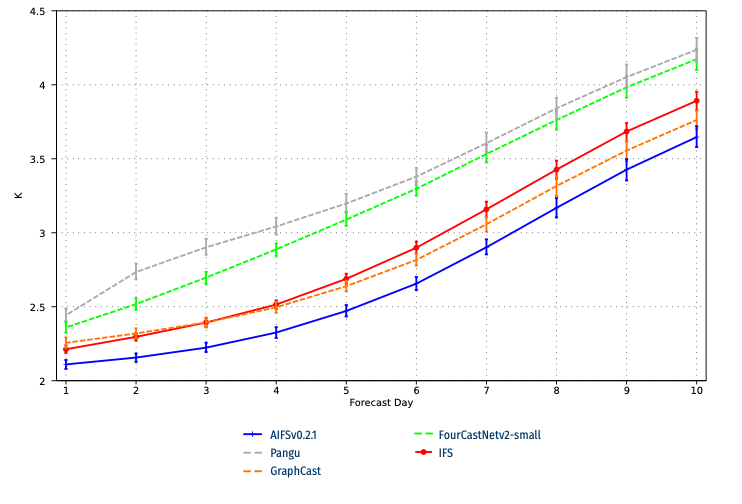

########
Figure 2. Two-metre temperature error evolution over a 10-day forecast averaged over the southern hemisphere for the year 2022 from different AI modelling systems (Huawei’s Pangu-Weather (Bi et al., 2023), NVIDIA’s FourCastNet (Pathak et al., 2022), the AIFS (Lang et al., 2024) and Google Deepmind’s GraphCast (Lam et al., 2023) with the physical model IFS as a reference (lower error is better). Notably, each of the AI 10-day forecasts takes less than one minute to produce on a single graphics processing unit (GPU).
########
The European Centre for Medium‐Range Weather Forecasts (ECMWF) has undertaken routine evaluation of AI weather models trained on ERA5, a global climate reanalysis combining observational data with models to provide hourly updates on atmospheric conditions (Figure 2). Predictions of severe weather events like windstorms, extreme temperatures and tropical cyclones were analyzed and the results show that current ML models consistently perform well with some li

 25%|██▌       | 2/8 [00:04<00:14,  2.36s/it]


Huawei's Pangu-Weather (Bi et al., 2023) performed best in forecasting certain weather situations.



SAMPLE 3 ##############################


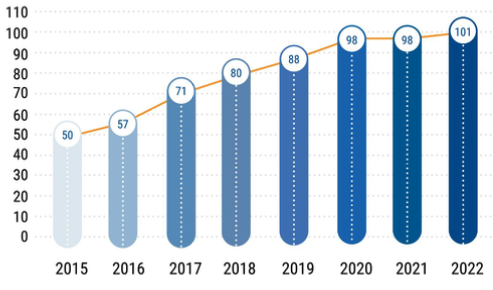

########
Figure 1. Cumulative number of countries reporting the existence of MHEWS. Source: WMO and UNDRR, 2023
########
Progress has been made in enhancing country capacities and coverage of MHEWS, with more than half of the world’s countries now reporting having MHEWS. According to the report on the Global Status of Multi-Hazard Early Warning Systems (WMO and UNDRR, 2023), 101 countries, or 52% of all countries globally, have reported the existence of MHEWS – an increase from the 2022 report and a doubling from the 2015 baseline (Figure 1). In particular, Arab States and countries in Asia and the Pacific, Europe and Central Asia have reported a significant increase in MHEWS coverage. However, while there has been progress across many regions, some still face significant gaps in coverage, including in Africa, the Americas and the Caribbean. Additionally, progress in least developed countries (LDCs) and small island developing States (SIDS) remains low, with less than 50% reporting MHE

 38%|███▊      | 3/8 [00:06<00:08,  1.75s/it]


In the year 2020, 88 countries have built MHEWS.



SAMPLE 4 ##############################


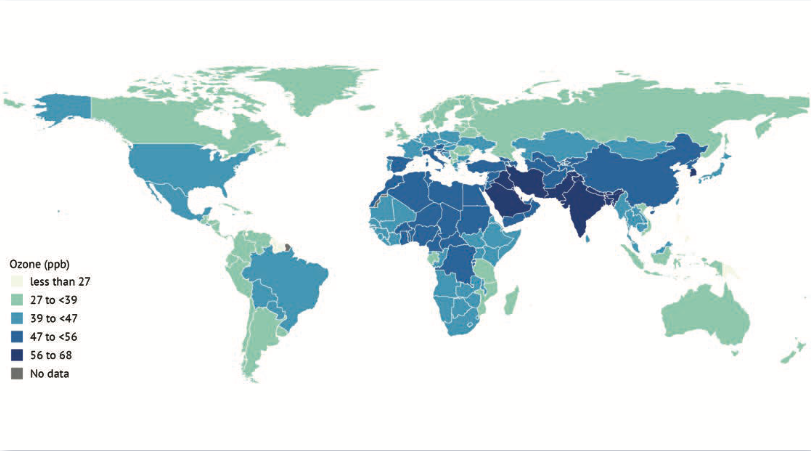

########
 Global map of national population-weighted average seasonal 8-hour daily maximum ozone concentrations in 2020 .
########
In 2020, ozone exposures varied from a low of about 11 .4 ppb to ahigh of 67 .6 ppb around the world, with a global average of 49 .8 ppb (Figure 7) . Countries with the highest average ozone exposures in 2020 were in the Middle East (Qatar, Bahrain, Kuwait, Saudi Arabia, and Iraq), South Asia (Nepal, India, Bangladesh, and Pakistan), and East Asia (Republic of Korea) . Small tropical island states were among thecountries with the lowest ozone exposures .
########
Tracking progress: In 2020, 93% of the world’s population lived in areaswith peak-season ozone levels higher than the WHO AQG for peak-season ozone (60 µg/m3 or 31 ppb) . In addition, the proportion of the population experiencing high ozoneexposures is increasing in many regions of the world . For example, countries including India, Nigeria, Pakistan, and Brazil have experienced increases of more t

 50%|█████     | 4/8 [00:07<00:06,  1.67s/it]


In South Asia, the estimated ozone exposure levels range from 11.4 ppb to 67.6 ppb.



SAMPLE 5 ##############################


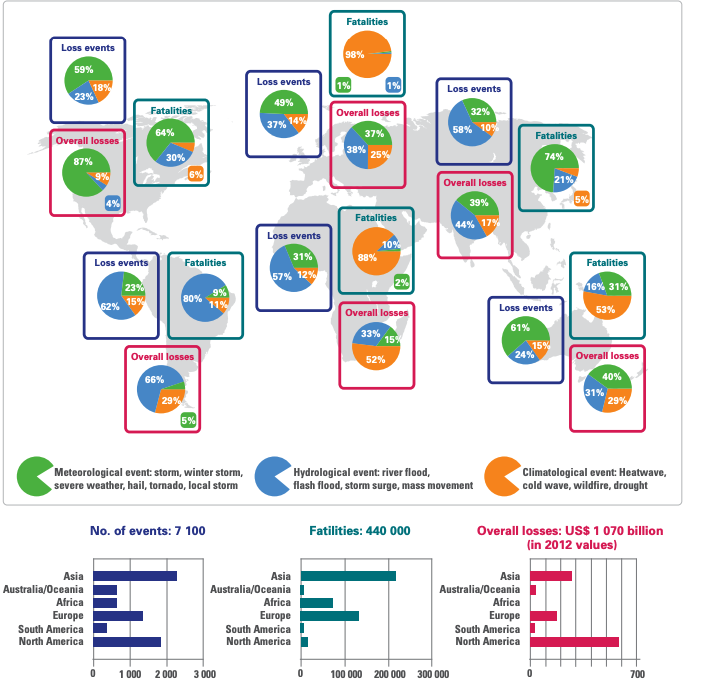

########
World map of hydrometeorological disasters, broken down by continent, 2001–2010 
########
Figure 18 shows the percentage of each category of loss from meteorological, hydrological and climatological events (see section 4.1.1 on data and methodology) and the percentage of fatalities and losses due to each category during the decade 2001–2010, by continent. The three lower histograms in the same figure provide the distribution by continent of the number of events (all three categories combined) and the resulting impacts in terms of fatalities and overall economic losses.
########
In North America during the decade 2001–2010, most of the disasters reported in the USA were of meteorological origin: numerous devastating storms and hurricanes accounted for the majority of natural disaster damage, amounting to more than US$ 502 billion. These were followed by climatological disasters (US$ 52 billion) and hydrological disasters (US$ 23 billion).
########
In Europe, Australia and Afric

 62%|██████▎   | 5/8 [00:08<00:04,  1.50s/it]


North America recorded the most Meteorological event.



SAMPLE 6 ##############################


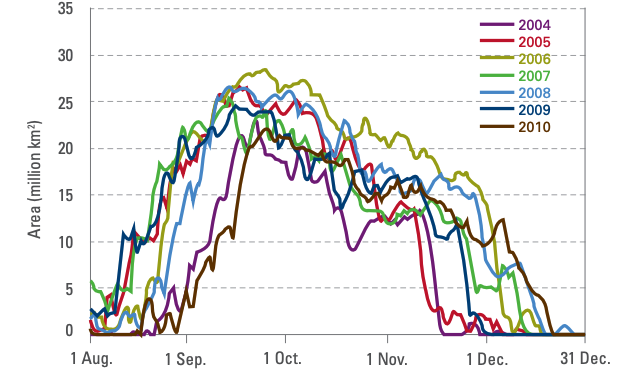

########
 Ozone hole area with respect to 220 DU in the southern hemisphere from August to December for the years 2004–2010; observationsmade by GOME and SCIAMACHY
########
The largest ozone hole areas were observed in 2000, 2003 and 2006. Figure 56 presents the evolution of the ozone hole area during 2004–2010. The largest ozone mass deficit occurred in 2000 and 2006, with loss being largest in 2006. One year stands out as different from all other recent years: 2002. During that year, the polar vortex split in two and broke down early in the season and the degree of ozone loss was limited compared with other years
########
The first ozone hole appeared in 1980. During the decade that followed, its size increased more or less gradually from zero to about 25 million km2, averaged over the last 10 days of September. Since the early 1990s, the size of the annually recurring ozone hole has remained more or less stable. Several representative time periods are used to calculate the average s

 75%|███████▌  | 6/8 [00:09<00:02,  1.39s/it]


The ozone hole is at its largest around late September or early October, during the southern hemisphere spring.



SAMPLE 7 ##############################


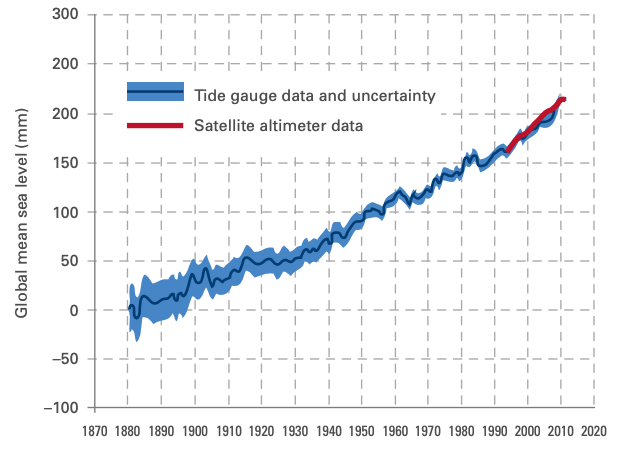

########
 Global time series of sea-level anomalies (mm) from 1880 to 2010, using tide gauges (blue line, with uncertainty in blue shading) and from 1993 to 2011, using satellite altimetry (red line)
########
The state of sea-ice cover in the 20th century is relatively well documented, largely because of the intensive exploration of the Arctic and existence of routine monitoring services which use, for example, ship observations, aerial reconnaissance and remotesensing. Since the 1970s, sea ice has been monitored from space. Until the 1960s, Arctic sea ice covered 14–16 million km2 in late winter and 7–9 million km2 at boreal summer’s end. Since the end of the 1960s, Arctic sea-ice extent has been showing a systematic, marked decline (Figure 59). An even more dramatic reduction in Arctic sea-ice extent was observed more recently. During the last six years of the decade (2005–2010), the lowest five September extents were recorded. Only 2006 was missing and the record minimum extent with

 88%|████████▊ | 7/8 [00:10<00:01,  1.25s/it]


The last measured sea level in mm was approximately 200 mm.



SAMPLE 8 ##############################


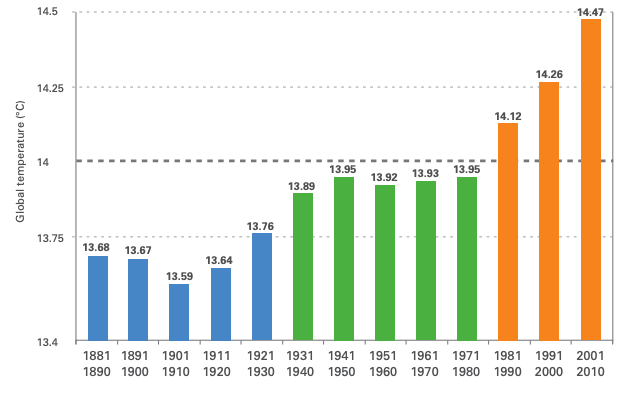

########
Figure 1. Decadal 14.5 global combined surface-air temperature over land and sea-surface temperature (°C) obtained from the average over the three independent datasets maintained by HadCRU, NOAA-NCDC and NASA-GISS. The horizontal grey line indicates the long-term average value (14.0°C) computed based on the 1961–1990 base period.
########
The decade 2001–2010 was the warmest decade since instrumental global average surface temperatures first became available in 1850 (Figure 1). Except for 2008, the remaining nine years of the decade were among the 10 warmest years on record, as warmer-than-average temperatures predominated across the globe. The global combined land air-surface and sea-surface mean temperature for 2001–2010 was estimated at 0.47°C ± 0.1°C above the 1961–1990 average of 14.0°C. The mean global temperature of this decade has increased by 0.88°C since the first decade of the past century (1901–1910).The warmest year on record was 2010, closely followed by 2005, wi

100%|██████████| 8/8 [00:12<00:00,  1.54s/it]


The long-term average of the global combined surface air temperature over land and sea was crossed in the year 2001.





In [12]:
import dataset
from tqdm import tqdm

data: list[list[dict]] = dataset.dataset
answers = list()

for i, (sample, question) in tqdm(enumerate(zip(data, questions)), total=len(data)):
    imgs = list()
    print(f"SAMPLE {i+1} ##############################")
    for s in sample:
        if "image" in s and s["image"] is not None:
            img = Image.open(s["image"])
            imgs.append(img)
            display(img)
        print("########")
        print(s["text"])
        
    print(f"\nQUESTION: {question}")
        
    print("\nANSWER:")
    answer = model.generate(question, sample, imgs)
    print(answer)
    print("\n\n")
    answers.append(answer)

# Inference & Results

In [14]:
import dataset
from tqdm import tqdm
import pandas as pd

data: list[list[dict]] = dataset.dataset
results = []
for model_id in ["gpt-4o-mini", "HuggingFaceM4/idefics2-8b-chatty"]:
    model = LLMFactory.get_model(model_id)
    for i, (sample, question) in tqdm(enumerate(zip(data, questions)), total=len(data)):
        imgs = [Image.open(s["image"]) for s in sample if "image" in s and s["image"] is not None]
        answer = model.generate(question, sample, imgs)
        results.append(
            {
                "model": model_id,
                "question": question,
                "answer": answer
            }
        )
        
df = pd.DataFrame(results)
df.to_csv("results.csv")
df.head()

100%|██████████| 8/8 [00:14<00:00,  1.76s/it]


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


,model,question,answer
0,gpt-4o-mini,What was the trend or progression of Arctic se...,The trend of Arctic sea ice cover between 1991...
1,gpt-4o-mini,Which AI Model did perform best in forecasting...,I cannot answer this based on the provided inf...
2,gpt-4o-mini,How many countries build MHEWS in the year 2020?,"In the year 2020, 98 countries reported the ex..."
3,gpt-4o-mini,What are the estimated ozone exposure levels i...,"In South Asia, the estimated ozone exposure le..."
4,gpt-4o-mini,Where were the most Meteorological event recor...,The most meteorological events were recorded i...
